# Saving Array Quantities

## Overview

### Questions

* How can I save per-particle quantities for later analysis?
* How can I access that data?

### Objectives

* Show how to log **per-particle properties** to a **GSD** file.
* Explain how to read logged quantities from a **GSD** file.
* Mention that OVITO reads these quantities.

## Boilerplate code

In [1]:
import hoomd
import numpy
import gsd.hoomd
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

## Array quantities

You saw an example of logging a small 6-element array quantity in the previous section, the pressure tensor.
You can log larger arrays and per-particle quantities (e.g. energy and force) in a **GSD** file along with the trajectory and use [OVITO](https://www.ovito.org/) to color particles by energy, display force vectors, or utilize the data in your analysis and visualization workflow. 
When using OVITO, open the GSD file and all logged quantities will be available in the inspector and for use in the pipeline.

## Define the Simulation

This tutorial executes the Lennard-Jones particle simulation from the previous tutorial. 
See *Introduction to Molecular Dyamics* for a complete description of this code.

In [2]:
gpu = hoomd.device.GPU()
sim = hoomd.Simulation(device=gpu)
sim.create_state_from_gsd(filename='../01-Introducing-Molecular-Dynamics/random.gsd')

integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell()
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.NVT(kT=1.5, filter=hoomd.filter.All(), tau=1.0)
integrator.methods.append(nvt)
sim.operations.integrator = integrator
sim.run(0)

## Logging per-particle quantities

MD forces provide a number of loggable quantities including their contribution to the system energy, but also per-particle energy contributions (in `energies`) and per-particle forces, torques, and virials.

In [3]:
lj.loggables

{'state': 'state',
 'energy': 'scalar',
 'energies': 'particle',
 'forces': 'particle',
 'torques': 'particle',
 'virials': 'particle'}

By default, **Logger** will filter out loggable quantities that may be large or not needed in typical situations.
Pass `only_default=False` to allow **Logger** to include these quantities and add only the quantities you need:

In [4]:
logger = hoomd.logging.Logger(only_default=False)
logger.add(lj, quantities=['energies', 'forces'])

[('md', 'pair', 'LJ', 'energies'), ('md', 'pair', 'LJ', 'forces')]

## Writing per-particle quantities to a GSD file

In the previous section, you used a `Null` filter to produce GSD file with *only* logged data.
In this section, include all particles so that you can connect logged per-particle quantities with the particle properties.


In [5]:
gsd_writer = hoomd.write.GSD(filename='trajectory.gsd',
                             trigger=hoomd.trigger.Periodic(10000),
                             mode='wb',
                             filter=hoomd.filter.All(),
                             log=logger)
sim.operations.writers.append(gsd_writer)

Run the simulation:

In [6]:
sim.run(100000)

## Reading logged data from a GSD file

Use the `gsd` package to open the file:

In [7]:
traj = gsd.hoomd.open('trajectory.gsd', 'rb')

GSD prepends `particles/` to the logged name of per-particle quantities:

In [8]:
traj[0].log.keys()

dict_keys(['particles/md/pair/LJ/energies', 'particles/md/pair/LJ/forces'])

The quantities are `N_particles` length numpy arrays.
Here are a few slices:

In [9]:
traj[-1].log['particles/md/pair/LJ/energies'][0:10]

array([-4.63552128, -3.96603518, -4.67048387, -2.95538439, -4.45060362,
       -4.32331039, -4.50254148, -4.90351856, -4.94546736, -4.60738018])

In [10]:
traj[-1].log['particles/md/pair/LJ/forces'][0:10]

array([[-14.05428842,  -0.31160828,  22.58204757],
       [ 26.22275188,  -8.07926344,  22.10161124],
       [ -5.10376762,   3.00793308,   8.63631979],
       [ 16.00333309, -31.11316374, -23.24277621],
       [ -2.67330089,   9.94561725,  -2.11290612],
       [ 32.9781836 ,  19.13548704, -23.57811789],
       [  0.46049737,  -3.42021108,   1.39666458],
       [ -1.22240789,  -3.91480287, -11.89616757],
       [  1.05155117, -14.31397314, -18.00645954],
       [-19.7087635 ,   8.71556194,   7.90163559]])

You can use these arrays as inputs to any computation or plotting tools:

In [11]:
numpy.mean(traj[-1].log['particles/md/pair/LJ/forces'], axis=0)

array([-1.77635684e-18,  6.33271213e-16, -7.10542736e-17])

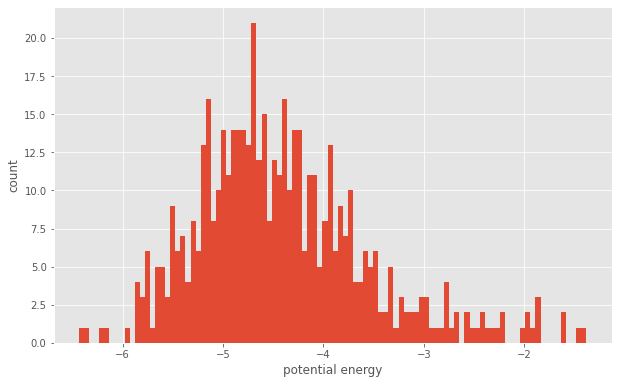

In [12]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.hist(traj[-1].log['particles/md/pair/LJ/energies'], 100)
ax.set_xlabel('potential energy')
ax.set_ylabel('count')
fig

As with scalar quantities, the array quantities are stored separately in each frame.
Use a loop to access a range of frames and compute time-series data or averages.

In this section, you have logged per-particle quantities to a GSD file during a simulation run and accessed that data with a script.
The next section of this tutorial will demonstrate how to log particle shape information that OVITO can use.

[Previous section](02-Writing-to-a-File.ipynb) / [Next section](04-Storing-Particle-Shape.ipynb)